# NCAA Basketbal Model Training

## **Installing and Importing the necessary libraries**

In [422]:
# Installing the libraries with the specified version
#!pip install tensorflow matplotlib seaborn numpy pandas scikit-learn keras

**Note**:
- After running the above cell, restart the runtime (for Google Colab) or notebook kernel (for Jupyter Notebook), and run all cells sequentially from the next cell.
- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in ***this notebook***.

In [423]:
# Library to help with saving and loading files
import pickle

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd
import openpyxl

# Library to split data
from sklearn.model_selection import train_test_split

# libaries to help with data visualization
import matplotlib.pyplot as plt

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 100)

# Libraries to get different metric scores
from sklearn import metrics
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

#Imports tools for data preprocessing including label encoding, one-hot encoding, and standard scaling
from sklearn.preprocessing import StandardScaler

# Time related functions.
import time

#Imports the tensorflow,keras and layers.
import tensorflow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Add, Dense, Input, Dropout,BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import load_model

# To ignore unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

## Data Loading and Preprocessing

### Read in Scores Data

In [424]:
# Load the scores data
with open("Scores.rds", "rb") as f:
    df_scores = pickle.load(f)

In [425]:
df_scores.tail()

,date_game,date_stat,team_name_home,team_score_home,team_name_away,team_score_away
1824,2025-11-24,2025-11-23,Maryland,NaN,UNLV,NaN
1825,2025-11-25,2025-11-24,North Alabama,NaN,Tennessee Wesleyan,NaN
1826,2025-11-23,2025-11-22,McNeese State,NaN,George Washington,NaN
1827,2025-11-24,2025-11-23,Bellarmine,NaN,Houston Christian,NaN
1828,2025-11-22,2025-11-21,Coastal Carolina,NaN,North Dakota,NaN


### Read in Stats Data

In [426]:
def load_rds(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

# Load the stats data
df_stats_away = load_rds("Stats_Away.rds")
df_stats_home = load_rds("Stats_Home.rds")

In [427]:
# Check first 5 rows of home stats for a specific date
df_stats_home['2025-11-10'].head()

# Write the df_stats_home['2025-11-10'] to excel for easier viewing
with pd.ExcelWriter('NCAAB_2025_2026_Data.xlsx') as writer:
    df_stats_home['2025-11-10'].to_excel(writer, sheet_name='Home_Stats_2025_11_10', index=False)

In [428]:
# Check first 5 rows of away stats for a specific date
df_stats_away['2025-11-20'].head()

,Date,Team,offensive-efficiency,offensive-efficiency.Last3,offensive-efficiency.Last1,offensive-efficiency.Away,three-point-pct,three-point-pct.Last3,three-point-pct.Last1,three-point-pct.Away,two-point-pct,two-point-pct.Last3,two-point-pct.Last1,two-point-pct.Away,free-throw-pct,free-throw-pct.Last3,free-throw-pct.Last1,free-throw-pct.Away,percent-of-points-from-3-pointers,percent-of-points-from-3-pointers.Last3,percent-of-points-from-3-pointers.Last1,percent-of-points-from-3-pointers.Away,points-per-game,points-per-game.Last3,points-per-game.Last1,points-per-game.Away,three-pointers-made-per-game,three-pointers-made-per-game.Last3,three-pointers-made-per-game.Last1,three-pointers-made-per-game.Away,free-throws-made-per-game,free-throws-made-per-game.Last3,free-throws-made-per-game.Last1,free-throws-made-per-game.Away,floor-percentage,floor-percentage.Last3,floor-percentage.Last1,floor-percentage.Away,turnovers-per-possession,turnovers-per-possession.Last3,turnovers-per-possession.Last1,turnovers-per-possession.Away,turnovers-per-game,turnovers-per-game.Last3,turnovers-per-game.Last1,turnovers-per-game.Away,assists-per-game,assists-per-game.Last3,assists-per-game.Last1,assists-per-game.Away,possessions-per-game,possessions-per-game.Last3,possessions-per-game.Last1,possessions-per-game.Away,offensive-rebounding-pct,offensive-rebounding-pct.Last3,offensive-rebounding-pct.Last1,offensive-rebounding-pct.Away,defensive-rebounding-pct,defensive-rebounding-pct.Last3,defensive-rebounding-pct.Last1,defensive-rebounding-pct.Away,total-rebounds-per-game,total-rebounds-per-game.Last3,total-rebounds-per-game.Last1,total-rebounds-per-game.Away,total-rebounding-percentage,total-rebounding-percentage.Last3,total-rebounding-percentage.Last1,total-rebounding-percentage.Away,extra-chances-per-game,extra-chances-per-game.Last3,extra-chances-per-game.Last1,extra-chances-per-game.Away,defensive-efficiency,defensive-efficiency.Last3,defensive-efficiency.Last1,defensive-efficiency.Away,blocks-per-game,blocks-per-game.Last3,blocks-per-game.Last1,blocks-per-game.Away,steals-per-game,steals-per-game.Last3,steals-per-game.Last1,steals-per-game.Away,block-pct,block-pct.Last3,block-pct.Last1,block-pct.Away,steals-perpossession,steals-perpossession.Last3,steals-perpossession.Last1,steals-perpossession.Away,personal-fouls-per-possession,personal-fouls-per-possession.Last3,personal-fouls-per-possession.Last1,personal-fouls-per-possession.Away,win-pct-all-games,win-pct-all-games.Last3,win-pct-all-games.Last1,win-pct-all-games.Away,effective-possession-ratio,effective-possession-ratio.Last3,effective-possession-ratio.Last1,effective-possession-ratio.Away,opponent-effective-possession-ratio,opponent-effective-possession-ratio.Last3,opponent-effective-possession-ratio.Last1,opponent-effective-possession-ratio.Away,schedule-strength-by-other,predictive-by-other,consistency-by-other
0,2025-11-20,Team,2025,Last 3,Last 1,Away,2025,Last 3,Last 1,Away,2025,Last 3,Last 1,Away,2025,Last 3,Last 1,Away,2025,Last 3,Last 1,Away,2025,Last 3,Last 1,Away,2025,Last 3,Last 1,Away,2025,Last 3,Last 1,Away,2025,Last 3,Last 1,Away,2025,Last 3,Last 1,Away,2025,Last 3,Last 1,Away,2025,Last 3,Last 1,Away,2025,Last 3,Last 1,Away,2025,Last 3,Last 1,Away,2025,Last 3,Last 1,Away,2025,Last 3,Last 1,Away,2025,Last 3,Last 1,Away,2025,Last 3,Last 1,Away,2025,Last 3,Last 1,Away,2025,Last 3,Last 1,Away,2025,Last 3,Last 1,Away,2025,Last 3,Last 1,Away,2025,Last 3,Last 1,Away,2025,Last 3,Last 1,Away,2025,Last 3,Last 1,Away,2025,Last 3,Last 1,Away,2025,Last 3,Last 1,Away,Rating,Rating,Rating
1,2025-11-20,Colorado St,1.357,1.313,1.275,1.275,45.0%,43.2%,46.7%,46.7%,61.1%,58.3%,45.8%,45.8%,88.2%,87.5%,84.2%,84.2%,44.0%,45.6%,52.5%,52.5%,92.0,90.0,80.0,80.0,13.5,13.7,14.0,14.0,22.5,21.0,16.0,16.0,58.9%,56.7%,53.9%,53.9%,15.1%,15.1%,14.3%,14.3%,10.3,10.3,9.0,9.0,20.8,20.3,19.0,19.0,67.8,68.6,62.7,62.7,34.0%,32.9%,33.3%,33.3%,80.1%,79.0%,76.0%,76.0%,39.0,37.7,32.0,32.0,60.5%,57.9%,55.2%,55.2%,0.8,2.3,7.0,

### Read in Injuries Data

In [429]:
# Read in Injuries Data - ncaab_injury_dataframes_2025_2026.rds
with open("ncaab_injury_dataframes_2025_2026.rds", "rb") as f:
    injury_df_dict = pickle.load(f)

In [430]:
# Check first 5 rows of injury data for a specific date
injury_df_dict['2025-11-10'].head()

,matchup_id,team,player,position,status,date,note
0,365396,Northwestern,B.\n ...,G,"Questionable - Undisclosed(\n\n\nNov 02, '25)","Nov 02, '25",Expand
1,365397,Utah,B.\n ...,F,"Out - Leg(\n\n\nSep 21, '25)","Sep 21, '25",Expand
2,365398,UConn,T.\n ...,C,"Questionable - Ankle(\n\n\nNov 18, '25)","Nov 18, '25",Expand
3,365398,UConn,B.\n ...,G,"Questionable - Ankle(\n\n\nOct 23, '25)","Oct 23, '25",Expand
4,365399,Iowa State,M.\n ...,G,"Out - Hip(\n\n\nJun 19, '25)","Jun 19, '25",Expand


### Read in Crosswalk

In [431]:
# Read in names crosswalk
df_crosswalk = pd.read_excel("teamNamesSR.xlsx")


In [432]:
# Create name mappings for Sports Reference to TeamRankings
name_map = dict(zip(df_crosswalk["SportsReferenceName"], df_crosswalk["TeamRankingsName"]))

In [433]:
# Create name mappings for Sports Reference to Covers.com names
name_map_covers = dict(zip(df_crosswalk["TeamRankingsName"], df_crosswalk["CoversNames"]))

In [434]:
# Make a copy of the scores data
df_scores_mapped = df_scores.copy()

In [435]:
# Replace team names in the scores dataframe
df_scores_mapped["team_name_home"] = df_scores_mapped["team_name_home"].map(name_map)
df_scores_mapped["team_name_away"] = df_scores_mapped["team_name_away"].map(name_map)

In [436]:
# Replace team names in the injury dataframes to match the mapped names in scores if team is present as a column
for date, df in injury_df_dict.items():
    if 'team' in df.columns:
        df['team'] = df['team'].map(name_map)
    injury_df_dict[date] = df

# Verify the name mapping by checking unique team names in injury data for all dates
unique_teams_injuries = set()
for date, df in injury_df_dict.items():
    if 'team' in df.columns:
        unique_teams_injuries.update(df['team'].dropna().unique())
print("Unique team names in injury data after mapping:")
print(unique_teams_injuries)



Unique team names in injury data after mapping:
{'Oklahoma St', 'San Francisco', 'Boston U', 'TCU', 'Siena', 'Washington St', 'Oakland', 'Utah', 'Indiana', 'Kentucky', 'Ohio St', 'Washington', 'Northwestern', 'Michigan', 'Auburn', 'Xavier', 'Missouri', 'Colorado St', 'Georgetown', 'Saint Louis', 'App State', 'Seton Hall', 'California', 'Memphis', 'West Virginia', 'Mississippi St', 'Kennesaw St', 'UConn', 'UCLA', 'SMU', 'Arizona St', 'Dayton', 'Notre Dame', 'Marquette', 'Purdue', 'Michigan St', 'Baylor', 'BYU', 'Sacramento St', 'Duquesne', 'E Washington', 'Duke', 'E Carolina', 'Rhode Island', 'Fordham', 'Alabama', 'Loyola Mymt', 'George Mason', 'UNLV', 'Liberty', 'DePaul', 'Creighton', 'VMI', 'Rutgers', 'Georgia St', 'Iowa St', 'Colorado', 'Houston', 'Texas A&M', 'Stanford', 'Nebraska', 'Kansas', 'Minnesota', 'Oregon', 'Maryland', 'USC', 'Virginia', 'Canisius', 'Villanova', 'Butler', 'Delaware', 'Texas Tech', 'Penn St', 'Cincinnati', 'Vanderbilt', 'Syracuse', 'Tennessee', 'Illinois', 'P

In [437]:
# Drop NAs
#df_scores_mapped.dropna(subset=["team_name_home", "team_name_away"], inplace=True)

In [438]:
# Create of copy of the scores dataframe now with TeamRankings mapped names 
df_scores_TR = df_scores_mapped[[
    "date_game", "date_stat", "team_name_home", "team_score_home", "team_name_away", "team_score_away"
]].copy()

df_scores_TR.columns = [
    "Date.Game", "Date.Stat", "Home", "Home.Points", "Away", "Away.Points"
]

# Convert Team names to string
df_scores_TR = df_scores_TR.astype({
    "Home": str,
    "Away": str
})

# Save the mapped scores dataframe
with open("Scores_TR.rds", "wb") as f:
    pickle.dump(df_scores_TR, f)

In [439]:
# Check first 5 rows of scores
df_scores_TR.head()

,Date.Game,Date.Stat,Home,Home.Points,Away,Away.Points
0,2025-11-10,2025-11-09,UConn,89.0,Columbia,62.0
1,2025-11-10,2025-11-09,UCLA,83.0,nan,62.0
2,2025-11-10,2025-11-09,Iowa St,96.0,Mississippi St,80.0
3,2025-11-10,2025-11-09,E Kentucky,79.0,W Kentucky,87.0
4,2025-11-10,2025-11-09,Furman,89.0,nan,59.0


In [440]:
df_scores_TR.tail()

,Date.Game,Date.Stat,Home,Home.Points,Away,Away.Points
1824,2025-11-24,2025-11-23,Maryland,NaN,UNLV,NaN
1825,2025-11-25,2025-11-24,N Alabama,NaN,nan,NaN
1826,2025-11-23,2025-11-22,McNeese,NaN,G Washington,NaN
1827,2025-11-24,2025-11-23,nan,NaN,nan,NaN
1828,2025-11-22,2025-11-21,Coastal Car,NaN,North Dakota,NaN


In [441]:
df_scores_TR = df_scores_TR.dropna(subset=["Home", "Away"])
df_scores_TR = df_scores_TR[
    (df_scores_TR["Home"] != "nan") & (df_scores_TR["Away"] != "nan")
]

df_scores_TR.reset_index(drop=True, inplace=True)


In [442]:
# Check length of df_scores_TR
len(df_scores_TR)

667

In [443]:
# Merge stats with scores
df_master = pd.DataFrame()

# Iterate through each row in the scores dataframe and merge with corresponding stats
for index, row in df_scores_TR.iterrows():
    stat_date = row["Date.Stat"]
    stat_key = stat_date.isoformat()

    # Use latest stats if the date is missing
    key_home = stat_key if stat_key in df_stats_home else max(df_stats_home.keys())
    key_away = stat_key if stat_key in df_stats_away else max(df_stats_away.keys())

    home_stats = df_stats_home[key_home]
    away_stats = df_stats_away[key_away]

    if home_stats is None or away_stats is None:
        print(f"⚠️ Missing stats for {home_team} vs {away_team} on {stat_key}")
        continue

    home_team = row["Home"]
    away_team = row["Away"]

    # Filter for single-row stats
    home_team_stats = home_stats[home_stats["Team"] == home_team]
    away_team_stats = away_stats[away_stats["Team"] == away_team]

    #drop Team and Date columns
    home_team_stats = home_team_stats.drop(columns=["Team", "Date"])
    away_team_stats = away_team_stats.drop(columns=["Team", "Date"])

    # Proceed only if both teams have exactly one matching row
    if len(home_team_stats) == 1 and len(away_team_stats) == 1:
        row_df = pd.DataFrame([row.to_dict()])
        home_row = home_team_stats.iloc[[0]].reset_index(drop=True).add_prefix("Home_")
        away_row = away_team_stats.iloc[[0]].reset_index(drop=True).add_prefix("Away_")

        # Force clean index
        row_df.index = [0]
        home_row.index = [0]
        away_row.index = [0]

        # Merge safely
        merged_row = pd.concat([row_df, home_row, away_row], axis=1)
        df_master = pd.concat([df_master, merged_row], ignore_index=True)


    else:
        print(f"⚠️ Skipping: {home_team} or {away_team} on {stat_key} has ambiguous or missing stats.")


In [444]:
# If a column with a Home_[col_name].Home or Away_[col_name].Away suffix has -- values, use the corresponding value from the Home_[col_name] or Away_[col_name]
for col in df_master.columns:
    if col.startswith("Home_") and col.endswith(".Home"):
        base_col = col[len("Home_"):-len(".Home")]
        corresponding_col = "Home_" + base_col
        df_master.loc[df_master[col] == "--", col] = df_master.loc[df_master[col] == "--", corresponding_col]
    elif col.startswith("Away_") and col.endswith(".Away"):
        base_col = col[len("Away_"):-len(".Away")]
        corresponding_col = "Away_" + base_col
        df_master.loc[df_master[col] == "--", col] = df_master.loc[df_master[col] == "--", corresponding_col]

In [445]:
# Create a dataframe that counts the number of injuries per team per date
injury_counts_list = []
for date, df in injury_df_dict.items():
    if 'team' in df.columns:
        injury_counts = df['team'].value_counts().reset_index()
        injury_counts.columns = ['Team', 'Injury.Count']
        injury_counts['Date.Game'] = pd.to_datetime(date)
        injury_counts_list.append(injury_counts)

# convert injury_counts_list to a single dataframe
df_injury_counts = pd.concat(injury_counts_list, ignore_index=True)

In [446]:
len(df_injury_counts)

313

In [447]:
# Show the first 25 rows of the injury counts dataframe
df_injury_counts.head(25)

,Team,Injury.Count,Date.Game
0,Seton Hall,3,2025-11-10
1,Washington St,3,2025-11-10
2,Georgia St,3,2025-11-10
3,Saint Louis,3,2025-11-10
4,UConn,2,2025-11-10
5,Xavier,2,2025-11-10
6,Iowa St,1,2025-11-10
7,Northwestern,1,2025-11-10
8,Utah,1,2025-11-10
9,TCU,1,2025-11-10


In [448]:
# show data types for df_injury_counts
df_injury_counts.dtypes

Team                    object
Injury.Count             int64
Date.Game       datetime64[ns]
dtype: object

In [449]:
# convert df_master['Date.Game'] to datetime
df_master['Date.Game'] = pd.to_datetime(df_master['Date.Game'])
# show data types for df_master
df_master.dtypes

Date.Game                                         datetime64[ns]
Date.Stat                                                 object
Home                                                      object
Home.Points                                              float64
Away                                                      object
                                                       ...      
Away_opponent-effective-possession-ratio.Last1            object
Away_opponent-effective-possession-ratio.Away             object
Away_schedule-strength-by-other                           object
Away_predictive-by-other                                  object
Away_consistency-by-other                                 object
Length: 228, dtype: object

In [450]:
# Merge injury counts with the master dataframe by Date.Game and either Home or Away based on the match for Date.Game
# If team names are missing, fill with 0 injuries
df_master = pd.merge(
    df_master,
    df_injury_counts.rename(columns={"Team": "Home", "Injury.Count": "Home_Injury.Count"}),
    on=["Date.Game", "Home"],
    how="left"
)

df_master = pd.merge(
    df_master,
    df_injury_counts.rename(columns={"Team": "Away", "Injury.Count": "Away_Injury.Count"}),
    on=["Date.Game", "Away"],
    how="left"
)

# Fill missing injury counts with 0
df_master["Home_Injury.Count"] = df_master["Home_Injury.Count"].fillna(0).astype(int)
df_master["Away_Injury.Count"] = df_master["Away_Injury.Count"].fillna(0).astype(int)



In [451]:
# Check first 5 rows of the master dataframe
df_master.head()

,Date.Game,Date.Stat,Home,Home.Points,Away,Away.Points,Home_offensive-efficiency,Home_offensive-efficiency.Last3,Home_offensive-efficiency.Last1,Home_offensive-efficiency.Home,Home_three-point-pct,Home_three-point-pct.Last3,Home_three-point-pct.Last1,Home_three-point-pct.Home,Home_two-point-pct,Home_two-point-pct.Last3,Home_two-point-pct.Last1,Home_two-point-pct.Home,Home_free-throw-pct,Home_free-throw-pct.Last3,Home_free-throw-pct.Last1,Home_free-throw-pct.Home,Home_percent-of-points-from-3-pointers,Home_percent-of-points-from-3-pointers.Last3,Home_percent-of-points-from-3-pointers.Last1,Home_percent-of-points-from-3-pointers.Home,Home_points-per-game,Home_points-per-game.Last3,Home_points-per-game.Last1,Home_points-per-game.Home,Home_three-pointers-made-per-game,Home_three-pointers-made-per-game.Last3,Home_three-pointers-made-per-game.Last1,Home_three-pointers-made-per-game.Home,Home_free-throws-made-per-game,Home_free-throws-made-per-game.Last3,Home_free-throws-made-per-game.Last1,Home_free-throws-made-per-game.Home,Home_floor-percentage,Home_floor-percentage.Last3,Home_floor-percentage.Last1,Home_floor-percentage.Home,Home_turnovers-per-possession,Home_turnovers-per-possession.Last3,Home_turnovers-per-possession.Last1,Home_turnovers-per-possession.Home,Home_turnovers-per-game,Home_turnovers-per-game.Last3,Home_turnovers-per-game.Last1,Home_turnovers-per-game.Home,Home_assists-per-game,Home_assists-per-game.Last3,Home_assists-per-game.Last1,Home_assists-per-game.Home,Home_possessions-per-game,Home_possessions-per-game.Last3,Home_possessions-per-game.Last1,Home_possessions-per-game.Home,Home_offensive-rebounding-pct,Home_offensive-rebounding-pct.Last3,Home_offensive-rebounding-pct.Last1,Home_offensive-rebounding-pct.Home,Home_defensive-rebounding-pct,Home_defensive-rebounding-pct.Last3,Home_defensive-rebounding-pct.Last1,Home_defensive-rebounding-pct.Home,Home_total-rebounds-per-game,Home_total-rebounds-per-game.Last3,Home_total-rebounds-per-game.Last1,Home_total-rebounds-per-game.Home,Home_total-rebounding-percentage,Home_total-rebounding-percentage.Last3,Home_total-rebounding-percentage.Last1,Home_total-rebounding-percentage.Home,Home_extra-chances-per-game,Home_extra-chances-per-game.Last3,Home_extra-chances-per-game.Last1,Home_extra-chances-per-game.Home,Home_defensive-efficiency,Home_defensive-efficiency.Last3,Home_defensive-efficiency.Last1,Home_defensive-efficiency.Home,Home_blocks-per-game,Home_blocks-per-game.Last3,Home_blocks-per-game.Last1,Home_blocks-per-game.Home,Home_steals-per-game,Home_steals-per-game.Last3,Home_steals-per-game.Last1,Home_steals-per-game.Home,Home_block-pct,Home_block-pct.Last3,Home_block-pct.Last1,Home_block-pct.Home,Home_steals-perpossession,Home_steals-perpossession.Last3,Home_steals-perpossession.Last1,Home_steals-perpossession.Home,Home_personal-fouls-per-possession,Home_personal-fouls-per-possession.Last3,Home_personal-fouls-per-possession.Last1,Home_personal-fouls-per-possession.Home,Home_win-pct-all-games,Home_win-pct-all-games.Last3,Home_win-pct-all-games.Last1,Home_win-pct-all-games.Home,Home_effective-possession-ratio,Home_effective-possession-ratio.Last3,Home_effective-possession-ratio.Last1,Home_effective-possession-ratio.Home,Home_opponent-effective-possession-ratio,Home_opponent-effective-possession-ratio.Last3,Home_opponent-effective-possession-ratio.Last1,Home_opponent-effective-possession-ratio.Home,Home_schedule-strength-by-other,Home_predictive-by-other,Home_consistency-by-other,Away_offensive-efficiency,Away_offensive-efficiency.Last3,Away_offensive-efficiency.Last1,Away_offensive-efficiency.Away,Away_three-point-pct,Away_three-point-pct.Last3,Away_three-point-pct.Last1,Away_three-point-pct.Away,Away_two-point-pct,Away_two-point-pct.Last3,Away_two-point-pct.Last1,Away_two-point-pct.Away,Away_free-throw-pct,Away_free-throw-pct.Last3,Away_free-throw-pct.Last1,Away_free-throw-pct.Away,Away_percent-of-points-from-3-pointers,Away_percent-of-points-from-3-pointers.Last3,Away_pe

In [452]:
# Show the values counts for Home_Injury.Count and Away_Injury.Count
df_master['Home_Injury.Count'].value_counts(), df_master['Away_Injury.Count'].value_counts()

(Home_Injury.Count
 0    470
 1    101
 2     59
 3     24
 4      9
 5      2
 8      1
 6      1
 Name: count, dtype: int64,
 Away_Injury.Count
 0    580
 1     53
 2     14
 3     10
 4      6
 5      3
 6      1
 Name: count, dtype: int64)

In [453]:
# convert Home_predictive-by-other and Away_predictive-by-other to numeric
df_master['Home_predictive-by-other'] = pd.to_numeric(df_master['Home_predictive-by-other'], errors='coerce')
df_master['Away_predictive-by-other'] = pd.to_numeric(df_master['Away_predictive-by-other'], errors='coerce')

# Identify the Favorite and Underdog via predictive-by-other rating, the team with higher rating is the favorite, do not use .apply for performance
df_master['Favorite'] = np.where(
    df_master['Home_predictive-by-other'] > df_master['Away_predictive-by-other'],
    df_master['Home'],
    df_master['Away']
)
df_master['Underdog'] = np.where(
    df_master['Home_predictive-by-other'] > df_master['Away_predictive-by-other'],
    df_master['Away'],
    df_master['Home']
)
# Identify the Favorite and Underdog via predictive-by-other rating, the team with higher rating

#Move Favorite and Underdog columns next 7th and 8th positions
cols = df_master.columns.tolist()
cols.insert(6, cols.pop(cols.index('Favorite')))
cols.insert(7, cols.pop(cols.index('Underdog')))
df_master = df_master[cols]

In [454]:
# Create target variables
df_master["Home.Points"] = pd.to_numeric(df_master["Home.Points"], errors="coerce")
df_master["Away.Points"] = pd.to_numeric(df_master["Away.Points"], errors="coerce")
df_master["Underdog.Win"] = ((df_master["Home.Points"] < df_master["Away.Points"]) & (df_master['Underdog'] == df_master['Away'])).astype(int)
df_master["Score.Diff"] = df_master["Home.Points"] - df_master["Away.Points"]
df_master["Total.Pts"] = df_master["Home.Points"] + df_master["Away.Points"]

In [455]:
# Move Underdog.Win, Score.Diff, and Total.Pts in dataframe to after Underdog column
underdog_win = df_master.pop("Underdog.Win")
score_diff = df_master.pop("Score.Diff")
total_pts = df_master.pop("Total.Pts")
df_master.insert(8, "Underdog.Win", underdog_win)
df_master.insert(9, "Score.Diff", score_diff)
df_master.insert(10, "Total.Pts", total_pts)

In [456]:
df_master.head()

,Date.Game,Date.Stat,Home,Home.Points,Away,Away.Points,Favorite,Underdog,Underdog.Win,Score.Diff,Total.Pts,Home_offensive-efficiency,Home_offensive-efficiency.Last3,Home_offensive-efficiency.Last1,Home_offensive-efficiency.Home,Home_three-point-pct,Home_three-point-pct.Last3,Home_three-point-pct.Last1,Home_three-point-pct.Home,Home_two-point-pct,Home_two-point-pct.Last3,Home_two-point-pct.Last1,Home_two-point-pct.Home,Home_free-throw-pct,Home_free-throw-pct.Last3,Home_free-throw-pct.Last1,Home_free-throw-pct.Home,Home_percent-of-points-from-3-pointers,Home_percent-of-points-from-3-pointers.Last3,Home_percent-of-points-from-3-pointers.Last1,Home_percent-of-points-from-3-pointers.Home,Home_points-per-game,Home_points-per-game.Last3,Home_points-per-game.Last1,Home_points-per-game.Home,Home_three-pointers-made-per-game,Home_three-pointers-made-per-game.Last3,Home_three-pointers-made-per-game.Last1,Home_three-pointers-made-per-game.Home,Home_free-throws-made-per-game,Home_free-throws-made-per-game.Last3,Home_free-throws-made-per-game.Last1,Home_free-throws-made-per-game.Home,Home_floor-percentage,Home_floor-percentage.Last3,Home_floor-percentage.Last1,Home_floor-percentage.Home,Home_turnovers-per-possession,Home_turnovers-per-possession.Last3,Home_turnovers-per-possession.Last1,Home_turnovers-per-possession.Home,Home_turnovers-per-game,Home_turnovers-per-game.Last3,Home_turnovers-per-game.Last1,Home_turnovers-per-game.Home,Home_assists-per-game,Home_assists-per-game.Last3,Home_assists-per-game.Last1,Home_assists-per-game.Home,Home_possessions-per-game,Home_possessions-per-game.Last3,Home_possessions-per-game.Last1,Home_possessions-per-game.Home,Home_offensive-rebounding-pct,Home_offensive-rebounding-pct.Last3,Home_offensive-rebounding-pct.Last1,Home_offensive-rebounding-pct.Home,Home_defensive-rebounding-pct,Home_defensive-rebounding-pct.Last3,Home_defensive-rebounding-pct.Last1,Home_defensive-rebounding-pct.Home,Home_total-rebounds-per-game,Home_total-rebounds-per-game.Last3,Home_total-rebounds-per-game.Last1,Home_total-rebounds-per-game.Home,Home_total-rebounding-percentage,Home_total-rebounding-percentage.Last3,Home_total-rebounding-percentage.Last1,Home_total-rebounding-percentage.Home,Home_extra-chances-per-game,Home_extra-chances-per-game.Last3,Home_extra-chances-per-game.Last1,Home_extra-chances-per-game.Home,Home_defensive-efficiency,Home_defensive-efficiency.Last3,Home_defensive-efficiency.Last1,Home_defensive-efficiency.Home,Home_blocks-per-game,Home_blocks-per-game.Last3,Home_blocks-per-game.Last1,Home_blocks-per-game.Home,Home_steals-per-game,Home_steals-per-game.Last3,Home_steals-per-game.Last1,Home_steals-per-game.Home,Home_block-pct,Home_block-pct.Last3,Home_block-pct.Last1,Home_block-pct.Home,Home_steals-perpossession,Home_steals-perpossession.Last3,Home_steals-perpossession.Last1,Home_steals-perpossession.Home,Home_personal-fouls-per-possession,Home_personal-fouls-per-possession.Last3,Home_personal-fouls-per-possession.Last1,Home_personal-fouls-per-possession.Home,Home_win-pct-all-games,Home_win-pct-all-games.Last3,Home_win-pct-all-games.Last1,Home_win-pct-all-games.Home,Home_effective-possession-ratio,Home_effective-possession-ratio.Last3,Home_effective-possession-ratio.Last1,Home_effective-possession-ratio.Home,Home_opponent-effective-possession-ratio,Home_opponent-effective-possession-ratio.Last3,Home_opponent-effective-possession-ratio.Last1,Home_opponent-effective-possession-ratio.Home,Home_schedule-strength-by-other,Home_predictive-by-other,Home_consistency-by-other,Away_offensive-efficiency,Away_offensive-efficiency.Last3,Away_offensive-efficiency.Last1,Away_offensive-efficiency.Away,Away_three-point-pct,Away_three-point-pct.Last3,Away_three-point-pct.Last1,Away_three-point-pct.Away,Away_two-point-pct,Away_two-point-pct.Last3,Away_two-point-pct.Last1,Away_two-point-pct.Away,Away_free-throw-pct,Away_free-throw-pct.Last3,Away_free-throw-pct.Last1,Away_free-throw-pct.Away,Away_percent-of-points-from-3-pointers,

In [457]:
len(df_master)

667

In [458]:
# Find the cutoff value for the top 150 teams for the predictive-by-other column in each key of df_stats_home
cutoff_values = {}
for key in df_stats_home.keys():
    if df_stats_home[key] is None:
        print(f"⚠️ Skipping {key}: no DataFrame")
        continue

    predictive_by_other_col = "predictive-by-other"
    if predictive_by_other_col in df_stats_home[key].columns:
        # get the values for the predictive-by-other column and assign to a variable as a list
        values = df_stats_home[key][predictive_by_other_col]
        # convert values to list
        values = pd.Series(values)
        # drop NAs
        #values = values.dropna()
        #drop 'Rating' if present
        values = values[values != 'Rating']
        # convert predictive-by-other to float
        values = values.astype(float)
        # sort values from largest to smallest
        sorted_values = values.sort_values(ascending=False).reset_index(drop=True)
        # get the value at index 149 (150th largest)
        top_200_cutoff = sorted_values.iloc[199]
        cutoff_values[key] = top_200_cutoff
# Show the cutoff values
print("Cutoff values for top 200 teams by 'predictive-by-other':")
print(cutoff_values)

Cutoff values for top 200 teams by 'predictive-by-other':
{'2025-11-09': np.float64(-2.7), '2025-11-10': np.float64(-2.6), '2025-11-11': np.float64(-2.6), '2025-11-12': np.float64(-2.6), '2025-11-13': np.float64(-2.6), '2025-11-14': np.float64(-2.6), '2025-11-15': np.float64(-2.6), '2025-11-16': np.float64(-2.7), '2025-11-17': np.float64(-2.5), '2025-11-18': np.float64(-2.4), '2025-11-19': np.float64(-2.4), '2025-11-20': np.float64(-2.4), '2025-11-21': np.float64(-2.6), '2025-11-22': np.float64(-2.6), '2025-11-23': np.float64(-2.6), '2025-11-24': np.float64(-2.5), '2025-11-25': np.float64(-2.3)}


In [459]:
# Only include rows where Home_predictive-by-other or Away_predictive-by-other is greater than or equal to the cutoff value for that date
df_filtered = pd.DataFrame()
for index, row in df_master.iterrows():
    stat_date = row["Date.Stat"]
    stat_key = stat_date.isoformat()
    home_team = row["Home"]
    away_team = row["Away"]

    # Get the cutoff value for the date
    cutoff_value = cutoff_values.get(stat_key, None)
    if cutoff_value is None:
        continue  # Skip if no cutoff value is found for the date

    # Get the predictive-by-other values for home and away teams
    home_stats = df_stats_home.get(stat_key, pd.DataFrame())
    away_stats = df_stats_away.get(stat_key, pd.DataFrame())

    home_predictive = home_stats.loc[home_stats['Team'] == home_team, 'predictive-by-other']
    away_predictive = away_stats.loc[away_stats['Team'] == away_team, 'predictive-by-other']

    if not home_predictive.empty and not away_predictive.empty:
        home_value = float(home_predictive.values[0])
        away_value = float(away_predictive.values[0])

        # Check if either team's predictive-by-other meets or exceeds the cutoff
        if home_value >= cutoff_value or away_value >= cutoff_value:
            df_filtered = pd.concat([df_filtered, pd.DataFrame([row])], ignore_index=True)

In [460]:
predictor_cols = df_filtered.columns[11:] 
df_filtered[predictor_cols] = df_filtered[predictor_cols].apply(lambda x: x.astype(str).str.replace("%", "")).apply(pd.to_numeric, errors="coerce")

# Drop rows with NAs in predictor columns
df_filtered.dropna(subset=predictor_cols, inplace=True)

In [461]:
len(df_filtered)

522

In [462]:
df_filtered.head()

,Date.Game,Date.Stat,Home,Home.Points,Away,Away.Points,Favorite,Underdog,Underdog.Win,Score.Diff,Total.Pts,Home_offensive-efficiency,Home_offensive-efficiency.Last3,Home_offensive-efficiency.Last1,Home_offensive-efficiency.Home,Home_three-point-pct,Home_three-point-pct.Last3,Home_three-point-pct.Last1,Home_three-point-pct.Home,Home_two-point-pct,Home_two-point-pct.Last3,Home_two-point-pct.Last1,Home_two-point-pct.Home,Home_free-throw-pct,Home_free-throw-pct.Last3,Home_free-throw-pct.Last1,Home_free-throw-pct.Home,Home_percent-of-points-from-3-pointers,Home_percent-of-points-from-3-pointers.Last3,Home_percent-of-points-from-3-pointers.Last1,Home_percent-of-points-from-3-pointers.Home,Home_points-per-game,Home_points-per-game.Last3,Home_points-per-game.Last1,Home_points-per-game.Home,Home_three-pointers-made-per-game,Home_three-pointers-made-per-game.Last3,Home_three-pointers-made-per-game.Last1,Home_three-pointers-made-per-game.Home,Home_free-throws-made-per-game,Home_free-throws-made-per-game.Last3,Home_free-throws-made-per-game.Last1,Home_free-throws-made-per-game.Home,Home_floor-percentage,Home_floor-percentage.Last3,Home_floor-percentage.Last1,Home_floor-percentage.Home,Home_turnovers-per-possession,Home_turnovers-per-possession.Last3,Home_turnovers-per-possession.Last1,Home_turnovers-per-possession.Home,Home_turnovers-per-game,Home_turnovers-per-game.Last3,Home_turnovers-per-game.Last1,Home_turnovers-per-game.Home,Home_assists-per-game,Home_assists-per-game.Last3,Home_assists-per-game.Last1,Home_assists-per-game.Home,Home_possessions-per-game,Home_possessions-per-game.Last3,Home_possessions-per-game.Last1,Home_possessions-per-game.Home,Home_offensive-rebounding-pct,Home_offensive-rebounding-pct.Last3,Home_offensive-rebounding-pct.Last1,Home_offensive-rebounding-pct.Home,Home_defensive-rebounding-pct,Home_defensive-rebounding-pct.Last3,Home_defensive-rebounding-pct.Last1,Home_defensive-rebounding-pct.Home,Home_total-rebounds-per-game,Home_total-rebounds-per-game.Last3,Home_total-rebounds-per-game.Last1,Home_total-rebounds-per-game.Home,Home_total-rebounding-percentage,Home_total-rebounding-percentage.Last3,Home_total-rebounding-percentage.Last1,Home_total-rebounding-percentage.Home,Home_extra-chances-per-game,Home_extra-chances-per-game.Last3,Home_extra-chances-per-game.Last1,Home_extra-chances-per-game.Home,Home_defensive-efficiency,Home_defensive-efficiency.Last3,Home_defensive-efficiency.Last1,Home_defensive-efficiency.Home,Home_blocks-per-game,Home_blocks-per-game.Last3,Home_blocks-per-game.Last1,Home_blocks-per-game.Home,Home_steals-per-game,Home_steals-per-game.Last3,Home_steals-per-game.Last1,Home_steals-per-game.Home,Home_block-pct,Home_block-pct.Last3,Home_block-pct.Last1,Home_block-pct.Home,Home_steals-perpossession,Home_steals-perpossession.Last3,Home_steals-perpossession.Last1,Home_steals-perpossession.Home,Home_personal-fouls-per-possession,Home_personal-fouls-per-possession.Last3,Home_personal-fouls-per-possession.Last1,Home_personal-fouls-per-possession.Home,Home_win-pct-all-games,Home_win-pct-all-games.Last3,Home_win-pct-all-games.Last1,Home_win-pct-all-games.Home,Home_effective-possession-ratio,Home_effective-possession-ratio.Last3,Home_effective-possession-ratio.Last1,Home_effective-possession-ratio.Home,Home_opponent-effective-possession-ratio,Home_opponent-effective-possession-ratio.Last3,Home_opponent-effective-possession-ratio.Last1,Home_opponent-effective-possession-ratio.Home,Home_schedule-strength-by-other,Home_predictive-by-other,Home_consistency-by-other,Away_offensive-efficiency,Away_offensive-efficiency.Last3,Away_offensive-efficiency.Last1,Away_offensive-efficiency.Away,Away_three-point-pct,Away_three-point-pct.Last3,Away_three-point-pct.Last1,Away_three-point-pct.Away,Away_two-point-pct,Away_two-point-pct.Last3,Away_two-point-pct.Last1,Away_two-point-pct.Away,Away_free-throw-pct,Away_free-throw-pct.Last3,Away_free-throw-pct.Last1,Away_free-throw-pct.Away,Away_percent-of-points-from-3-pointers,

In [463]:
# Show games where Alabama is playing
df_filtered[(df_filtered['Home'] == 'Alabama') | (df_filtered['Away'] == 'Alabama')]


,Date.Game,Date.Stat,Home,Home.Points,Away,Away.Points,Favorite,Underdog,Underdog.Win,Score.Diff,Total.Pts,Home_offensive-efficiency,Home_offensive-efficiency.Last3,Home_offensive-efficiency.Last1,Home_offensive-efficiency.Home,Home_three-point-pct,Home_three-point-pct.Last3,Home_three-point-pct.Last1,Home_three-point-pct.Home,Home_two-point-pct,Home_two-point-pct.Last3,Home_two-point-pct.Last1,Home_two-point-pct.Home,Home_free-throw-pct,Home_free-throw-pct.Last3,Home_free-throw-pct.Last1,Home_free-throw-pct.Home,Home_percent-of-points-from-3-pointers,Home_percent-of-points-from-3-pointers.Last3,Home_percent-of-points-from-3-pointers.Last1,Home_percent-of-points-from-3-pointers.Home,Home_points-per-game,Home_points-per-game.Last3,Home_points-per-game.Last1,Home_points-per-game.Home,Home_three-pointers-made-per-game,Home_three-pointers-made-per-game.Last3,Home_three-pointers-made-per-game.Last1,Home_three-pointers-made-per-game.Home,Home_free-throws-made-per-game,Home_free-throws-made-per-game.Last3,Home_free-throws-made-per-game.Last1,Home_free-throws-made-per-game.Home,Home_floor-percentage,Home_floor-percentage.Last3,Home_floor-percentage.Last1,Home_floor-percentage.Home,Home_turnovers-per-possession,Home_turnovers-per-possession.Last3,Home_turnovers-per-possession.Last1,Home_turnovers-per-possession.Home,Home_turnovers-per-game,Home_turnovers-per-game.Last3,Home_turnovers-per-game.Last1,Home_turnovers-per-game.Home,Home_assists-per-game,Home_assists-per-game.Last3,Home_assists-per-game.Last1,Home_assists-per-game.Home,Home_possessions-per-game,Home_possessions-per-game.Last3,Home_possessions-per-game.Last1,Home_possessions-per-game.Home,Home_offensive-rebounding-pct,Home_offensive-rebounding-pct.Last3,Home_offensive-rebounding-pct.Last1,Home_offensive-rebounding-pct.Home,Home_defensive-rebounding-pct,Home_defensive-rebounding-pct.Last3,Home_defensive-rebounding-pct.Last1,Home_defensive-rebounding-pct.Home,Home_total-rebounds-per-game,Home_total-rebounds-per-game.Last3,Home_total-rebounds-per-game.Last1,Home_total-rebounds-per-game.Home,Home_total-rebounding-percentage,Home_total-rebounding-percentage.Last3,Home_total-rebounding-percentage.Last1,Home_total-rebounding-percentage.Home,Home_extra-chances-per-game,Home_extra-chances-per-game.Last3,Home_extra-chances-per-game.Last1,Home_extra-chances-per-game.Home,Home_defensive-efficiency,Home_defensive-efficiency.Last3,Home_defensive-efficiency.Last1,Home_defensive-efficiency.Home,Home_blocks-per-game,Home_blocks-per-game.Last3,Home_blocks-per-game.Last1,Home_blocks-per-game.Home,Home_steals-per-game,Home_steals-per-game.Last3,Home_steals-per-game.Last1,Home_steals-per-game.Home,Home_block-pct,Home_block-pct.Last3,Home_block-pct.Last1,Home_block-pct.Home,Home_steals-perpossession,Home_steals-perpossession.Last3,Home_steals-perpossession.Last1,Home_steals-perpossession.Home,Home_personal-fouls-per-possession,Home_personal-fouls-per-possession.Last3,Home_personal-fouls-per-possession.Last1,Home_personal-fouls-per-possession.Home,Home_win-pct-all-games,Home_win-pct-all-games.Last3,Home_win-pct-all-games.Last1,Home_win-pct-all-games.Home,Home_effective-possession-ratio,Home_effective-possession-ratio.Last3,Home_effective-possession-ratio.Last1,Home_effective-possession-ratio.Home,Home_opponent-effective-possession-ratio,Home_opponent-effective-possession-ratio.Last3,Home_opponent-effective-possession-ratio.Last1,Home_opponent-effective-possession-ratio.Home,Home_schedule-strength-by-other,Home_predictive-by-other,Home_consistency-by-other,Away_offensive-efficiency,Away_offensive-efficiency.Last3,Away_offensive-efficiency.Last1,Away_offensive-efficiency.Away,Away_three-point-pct,Away_three-point-pct.Last3,Away_three-point-pct.Last1,Away_three-point-pct.Away,Away_two-point-pct,Away_two-point-pct.Last3,Away_two-point-pct.Last1,Away_two-point-pct.Away,Away_free-throw-pct,Away_free-throw-pct.Last3,Away_free-throw-pct.Last1,Away_free-throw-pct.Away,Away_percent-of-points-from-3-pointers,

In [464]:
# Prepare data for modeling
numeric_cols = df_filtered.columns[8:] 
df_analyze = df_filtered[numeric_cols].apply(lambda x: x.astype(str).str.replace("%", "")).apply(pd.to_numeric, errors="coerce")
df_analyze["Underdog.Win"] = df_filtered["Underdog.Win"].astype('int')
df_analyze["Score.Diff"] = df_filtered["Score.Diff"]
df_analyze["Total.Pts"] = df_filtered["Total.Pts"]
# Remove NaNs
df_analyze.dropna(inplace=True) 

In [465]:
df_analyze.head()

,Underdog.Win,Score.Diff,Total.Pts,Home_offensive-efficiency,Home_offensive-efficiency.Last3,Home_offensive-efficiency.Last1,Home_offensive-efficiency.Home,Home_three-point-pct,Home_three-point-pct.Last3,Home_three-point-pct.Last1,Home_three-point-pct.Home,Home_two-point-pct,Home_two-point-pct.Last3,Home_two-point-pct.Last1,Home_two-point-pct.Home,Home_free-throw-pct,Home_free-throw-pct.Last3,Home_free-throw-pct.Last1,Home_free-throw-pct.Home,Home_percent-of-points-from-3-pointers,Home_percent-of-points-from-3-pointers.Last3,Home_percent-of-points-from-3-pointers.Last1,Home_percent-of-points-from-3-pointers.Home,Home_points-per-game,Home_points-per-game.Last3,Home_points-per-game.Last1,Home_points-per-game.Home,Home_three-pointers-made-per-game,Home_three-pointers-made-per-game.Last3,Home_three-pointers-made-per-game.Last1,Home_three-pointers-made-per-game.Home,Home_free-throws-made-per-game,Home_free-throws-made-per-game.Last3,Home_free-throws-made-per-game.Last1,Home_free-throws-made-per-game.Home,Home_floor-percentage,Home_floor-percentage.Last3,Home_floor-percentage.Last1,Home_floor-percentage.Home,Home_turnovers-per-possession,Home_turnovers-per-possession.Last3,Home_turnovers-per-possession.Last1,Home_turnovers-per-possession.Home,Home_turnovers-per-game,Home_turnovers-per-game.Last3,Home_turnovers-per-game.Last1,Home_turnovers-per-game.Home,Home_assists-per-game,Home_assists-per-game.Last3,Home_assists-per-game.Last1,Home_assists-per-game.Home,Home_possessions-per-game,Home_possessions-per-game.Last3,Home_possessions-per-game.Last1,Home_possessions-per-game.Home,Home_offensive-rebounding-pct,Home_offensive-rebounding-pct.Last3,Home_offensive-rebounding-pct.Last1,Home_offensive-rebounding-pct.Home,Home_defensive-rebounding-pct,Home_defensive-rebounding-pct.Last3,Home_defensive-rebounding-pct.Last1,Home_defensive-rebounding-pct.Home,Home_total-rebounds-per-game,Home_total-rebounds-per-game.Last3,Home_total-rebounds-per-game.Last1,Home_total-rebounds-per-game.Home,Home_total-rebounding-percentage,Home_total-rebounding-percentage.Last3,Home_total-rebounding-percentage.Last1,Home_total-rebounding-percentage.Home,Home_extra-chances-per-game,Home_extra-chances-per-game.Last3,Home_extra-chances-per-game.Last1,Home_extra-chances-per-game.Home,Home_defensive-efficiency,Home_defensive-efficiency.Last3,Home_defensive-efficiency.Last1,Home_defensive-efficiency.Home,Home_blocks-per-game,Home_blocks-per-game.Last3,Home_blocks-per-game.Last1,Home_blocks-per-game.Home,Home_steals-per-game,Home_steals-per-game.Last3,Home_steals-per-game.Last1,Home_steals-per-game.Home,Home_block-pct,Home_block-pct.Last3,Home_block-pct.Last1,Home_block-pct.Home,Home_steals-perpossession,Home_steals-perpossession.Last3,Home_steals-perpossession.Last1,Home_steals-perpossession.Home,Home_personal-fouls-per-possession,Home_personal-fouls-per-possession.Last3,Home_personal-fouls-per-possession.Last1,Home_personal-fouls-per-possession.Home,Home_win-pct-all-games,Home_win-pct-all-games.Last3,Home_win-pct-all-games.Last1,Home_win-pct-all-games.Home,Home_effective-possession-ratio,Home_effective-possession-ratio.Last3,Home_effective-possession-ratio.Last1,Home_effective-possession-ratio.Home,Home_opponent-effective-possession-ratio,Home_opponent-effective-possession-ratio.Last3,Home_opponent-effective-possession-ratio.Last1,Home_opponent-effective-possession-ratio.Home,Home_schedule-strength-by-other,Home_predictive-by-other,Home_consistency-by-other,Away_offensive-efficiency,Away_offensive-efficiency.Last3,Away_offensive-efficiency.Last1,Away_offensive-efficiency.Away,Away_three-point-pct,Away_three-point-pct.Last3,Away_three-point-pct.Last1,Away_three-point-pct.Away,Away_two-point-pct,Away_two-point-pct.Last3,Away_two-point-pct.Last1,Away_two-point-pct.Away,Away_free-throw-pct,Away_free-throw-pct.Last3,Away_free-throw-pct.Last1,Away_free-throw-pct.Away,Away_percent-of-points-from-3-pointers,Away_percent-of-points-from-3-pointers.Last3,Away_percent-of-points-from

In [466]:
df_analyze['Underdog.Win'].value_counts()

Underdog.Win
0    386
1     55
Name: count, dtype: int64

In [467]:
len(df_analyze)

441

## Joint Model

### Preprocessing

In [468]:

# Define X and y
X = df_analyze.drop(['Underdog.Win','Score.Diff','Total.Pts'],axis=1)
y_spread = df_analyze["Score.Diff"]
y_winner = df_analyze["Underdog.Win"]

# convert y's to appropriate types
y_spread = y_spread.astype(float)
y_winner = y_winner.astype(int)

In [469]:
#Check columns and types present in X
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 441 entries, 3 to 474
Columns: 224 entries, Home_offensive-efficiency to Away_Injury.Count
dtypes: float64(222), int64(2)
memory usage: 775.2 KB


#### Data Splitting

In [470]:
# Split the dataset into train and validation/test
X_train, X_val, y_train_spread, y_val_spread = train_test_split(
    X, y_spread, test_size=0.3, random_state=1, stratify=None
)

# Split the validation/test dataset into validation and test
X_val,X_test,y_val_spread,y_test_spread = train_test_split(
    X_val,y_val_spread,test_size=0.33,random_state=1,stratify=None
)

In [471]:
# Split the dataset into train and validation/test
X_train, X_val, y_train_winner, y_val_winner = train_test_split(
    X, y_winner, test_size=0.3, random_state=1, stratify=None
)

# Split the validation/test dataset into validation and test
X_val,X_test,y_val_winner,y_test_winner = train_test_split(
    X_val,y_val_winner,test_size=0.33,random_state=1,stratify=None
)

In [472]:
print("Shape of Training set : ", X_train.shape)
print("Shape of Validation set : ", X_val.shape)
print("Shape of test set : ", X_test.shape)
print("Average point diff in training set:")
print(y_train_spread.shape)
print(y_train_spread.mean())
print("Underdog wins in training set:")
print(y_train_winner.shape)
print(y_train_winner.sum())
print("Average point diff in validation set:")
print(y_val_spread.mean())
print("Underdog wins in validation set:")
print(y_val_winner.sum())
print("Average point diff in test set:")
print(y_test_spread.mean())
print("Underdog wins in test set:")
print(y_test_winner.sum())

Shape of Training set :  (308, 224)
Shape of Validation set :  (89, 224)
Shape of test set :  (44, 224)
Average point diff in training set:
(308,)
11.12012987012987
Underdog wins in training set:
(308,)
41
Average point diff in validation set:
9.101123595505618
Underdog wins in validation set:
11
Average point diff in test set:
15.068181818181818
Underdog wins in test set:
3


In [473]:
#Convert y values to numpy arrarys
y_train_spread = y_train_spread.to_numpy()
y_val_spread = y_val_spread.to_numpy()
y_test_spread = y_test_spread.to_numpy()

In [474]:
#Convert y values to numpy arrarys
y_train_winner = y_train_winner.to_numpy()
y_val_winner = y_val_winner.to_numpy()
y_test_winner = y_test_winner.to_numpy()

In [475]:
#Standardize the numerical variables to zero mean and unit variance.
transformer = StandardScaler()
X_train = pd.DataFrame(transformer.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(transformer.fit_transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(transformer.fit_transform(X_test), columns=X_test.columns)

### Model 0: CNN with ADAM

In [476]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tensorflow.keras.backend.clear_session()

In [477]:
# Set Parameters
learning_rate = 0.00001
epochs = 500
batch_size = 32
dropout_rate = 0.2
l2_lambda = 0.001

In [478]:
# Input
inputs = Input(shape=(X_train.shape[1],))

# Shared hidden layers
x = Dense(256, activation="relu", kernel_initializer="he_normal", kernel_regularizer=l2(l2_lambda))(inputs)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)

x = Dense(128, activation="relu", kernel_initializer="he_normal", kernel_regularizer=l2(l2_lambda))(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)

x = Dense(64, activation="relu", kernel_regularizer=l2(l2_lambda))(x)
x = BatchNormalization()(x)

# --- Branch 1: Winner classification ---
winner_output = Dense(1, activation="sigmoid", name="winner")(x)

# --- Branch 2: Spread regression ---
spread_output = Dense(1, activation="linear", name="spread")(x)

# Define multi-output model
model_0 = Model(inputs=inputs, outputs=[winner_output, spread_output])



In [479]:
# Compile with different losses for each task

model_0.compile(
    optimizer="adam",
    loss={"winner": "binary_crossentropy", "spread": "mse"},
    metrics={
        "winner": ["accuracy", "auc","f1_score","precision","recall"],
        "spread": ["mae", "mse"]
    }
)


In [480]:
def f1_score_tf(y_true, y_pred):
    y_pred = tensorflow.round(tensorflow.clip_by_value(y_pred, 0, 1))
    y_true = tensorflow.cast(y_true, tensorflow.float32)

    tp = tensorflow.reduce_sum(tensorflow.cast(y_true * y_pred, tensorflow.float32))
    fp = tensorflow.reduce_sum(tensorflow.cast((1 - y_true) * y_pred, tensorflow.float32))
    fn = tensorflow.reduce_sum(tensorflow.cast(y_true * (1 - y_pred), tensorflow.float32))

    precision = tensorflow.math.divide_no_nan(tp, tp + fp)
    recall = tensorflow.math.divide_no_nan(tp, tp + fn)
    f1 = tensorflow.math.divide_no_nan(2 * precision * recall, precision + recall)
    return f1

model_0.compile(
    optimizer="adam",
    loss={"winner": "binary_crossentropy", "spread": "mse"},
    metrics={
        "winner": [
            "accuracy",
            tensorflow.keras.metrics.AUC(name="auc"),
            f1_score_tf,
            tensorflow.keras.metrics.Precision(name="precision"),
            tensorflow.keras.metrics.Recall(name="recall")
        ],
        "spread": [
            tensorflow.keras.metrics.MeanAbsoluteError(name="mae"),
            tensorflow.keras.metrics.MeanSquaredError(name="mse")
        ]
    }
)


In [481]:

class BalancedCheckpoint(Callback):
    def __init__(self, filepath):
        super().__init__()
        self.filepath = filepath
        self.best_score = -np.inf

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # Extract metrics
        class_metric = logs.get("val_winner_f1_score_tf")   # classification metric
        reg_metric = logs.get("val_spread_mse")        # regression metric

        if class_metric is not None and reg_metric is not None:
            rmse = np.sqrt(reg_metric)

            # Weighted balance: regression 0.8, classification 0.2
            # Normalize RMSE by dividing by 40 (approx typical spread range)
            reg_component = (1 - rmse / 40.0) * 0.8
            class_component = class_metric * 0.2

            combined_score = reg_component + class_component

            if combined_score > self.best_score:
                self.best_score = combined_score
                self.model.save(self.filepath)
                print(
                    f"\nEpoch {epoch+1}: "
                    f"New best weighted score {combined_score:.4f} "
                    f"(class={class_metric:.4f}, rmse={rmse:.4f}), model saved."
                )


In [482]:
y_train_winner = y_train_winner.reshape(-1, 1)
y_val_winner   = y_val_winner.reshape(-1, 1)
y_test_winner  = y_test_winner.reshape(-1, 1)

In [483]:
balanced_checkpoint = BalancedCheckpoint("best_model_joint.h5")

start = time.time()
history = model_0.fit(
    X_train,
    {"winner": y_train_winner, "spread": y_train_spread},
    validation_data=(X_val, {"winner": y_val_winner, "spread": y_val_spread}),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[balanced_checkpoint]
)
end = time.time()

Epoch 1/500
 1/10 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - loss: 447.6355 - spread_loss: 445.8641 - spread_mae: 17.5943 - spread_mse: 445.8641 - winner_accuracy: 0.4688 - winner_auc: 0.4333 - winner_f1_score_tf: 0.0000e+00 - winner_loss: 0.9185 - winner_precision: 0.0000e+00 - winner_recall: 0.0000e+00


Epoch 1: New best weighted score 0.4779 (class=0.2050, rmse=18.1537), model saved.
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - loss: 414.3836 - spread_loss: 414.2488 - spread_mae: 16.2019 - spread_mse: 412.6512 - winner_accuracy: 0.4935 - winner_auc: 0.4361 - winner_f1_score_tf: 0.1530 - winner_loss: 0.8832 - winner_precision: 0.1088 - winner_recall: 0.3902 - val_loss: 332.0312 - val_spread_loss: 340.9772 - val_spread_mae: 14.0458 - val_spread_mse: 329.5579 - val_winner_accuracy: 0.1236 - val_winner_auc: 0.4336 - val_winner_f1_score_tf: 0.2050 - val_winner_loss: 1.6346 - val_winner_precision: 0.1236 - val_winner_recall: 1.0000
Epoch 2/500
 5/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 405.3432 - spread_loss: 403.6122 - spread_mae: 16.3390 - spread_mse: 403.6122 - winner_accuracy: 0.4741 - winner_auc: 0.4041 - winner_f1_score_tf: 0.1169 - winner_loss: 0.8765 - winner_precision: 0.0727 - winner_recall: 0.3041 


Epoch 2: New best weighted score 0.4940 (class=0.2108, rmse=17.4077), model saved.
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 366.9112 - spread_loss: 363.5545 - spread_mae: 15.1659 - spread_mse: 365.2229 - winner_accuracy: 0.5162 - winner_auc: 0.4795 - winner_f1_score_tf: 0.1935 - winner_loss: 0.8310 - winner_precision: 0.1197 - winner_recall: 0.4146 - val_loss: 305.2735 - val_spread_loss: 313.2904 - val_spread_mae: 13.3812 - val_spread_mse: 303.0282 - val_winner_accuracy: 0.1461 - val_winner_auc: 0.4569 - val_winner_f1_score_tf: 0.2108 - val_winner_loss: 1.4019 - val_winner_precision: 0.1264 - val_winner_recall: 1.0000
Epoch 3/500
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 279.9695 - spread_loss: 278.1851 - spread_mae: 12.9322 - spread_mse: 278.1851 - winner_accuracy: 0.4062 - winner_auc: 0.1607 - winner_f1_score_tf: 0.0000e+00 - winner_loss: 0.9286 - winner_precision: 0.0000e+00 - winner_recall: 0.0000e+00


Epoch 3: New best weighted score 0.5033 (class=0.1974, rmse=16.8067), model saved.
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 339.4473 - spread_loss: 337.4653 - spread_mae: 14.5642 - spread_mse: 337.7809 - winner_accuracy: 0.5195 - winner_auc: 0.4999 - winner_f1_score_tf: 0.1800 - winner_loss: 0.8141 - winner_precision: 0.1151 - winner_recall: 0.3902 - val_loss: 284.5203 - val_spread_loss: 291.6713 - val_spread_mae: 12.8277 - val_spread_mse: 282.4639 - val_winner_accuracy: 0.1573 - val_winner_auc: 0.5023 - val_winner_f1_score_tf: 0.1974 - val_winner_loss: 1.2122 - val_winner_precision: 0.1190 - val_winner_recall: 0.9091
Epoch 4/500
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 473.2433 - spread_loss: 471.5656 - spread_mae: 19.1897 - spread_mse: 471.5656 - winner_accuracy: 0.5000 - winner_auc: 0.4833 - winner_f1_score_tf: 0.1111 - winner_loss: 0.8203 - winner_precision: 0.0625 - winner_recall: 0.5000


Epoch 4: New best weighted score 0.5195 (class=0.2336, rmse=16.3588), model saved.
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 315.1503 - spread_loss: 311.1046 - spread_mae: 14.1022 - spread_mse: 313.5137 - winner_accuracy: 0.5357 - winner_auc: 0.5305 - winner_f1_score_tf: 0.2093 - winner_loss: 0.7784 - winner_precision: 0.1458 - winner_recall: 0.5122 - val_loss: 269.4619 - val_spread_loss: 275.9288 - val_spread_mae: 12.6061 - val_spread_mse: 267.6100 - val_winner_accuracy: 0.3034 - val_winner_auc: 0.5495 - val_winner_f1_score_tf: 0.2336 - val_winner_loss: 1.0043 - val_winner_precision: 0.1408 - val_winner_recall: 0.9091
Epoch 5/500
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 230.7065 - spread_loss: 229.1430 - spread_mae: 12.9381 - spread_mse: 229.1430 - winner_accuracy: 0.5938 - winner_auc: 0.6071 - winner_f1_score_tf: 0.2353 - winner_loss: 0.7050 - winner_precision: 0.1538 - winner_recall: 0.5000


Epoch 5: New best weighted score 0.5281 (class=0.2318, rmse=15.9134), model saved.
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 286.1353 - spread_loss: 279.8229 - spread_mae: 13.3012 - spread_mse: 284.5478 - winner_accuracy: 0.5227 - winner_auc: 0.5861 - winner_f1_score_tf: 0.2069 - winner_loss: 0.7343 - winner_precision: 0.1370 - winner_recall: 0.4878 - val_loss: 254.9592 - val_spread_loss: 260.8238 - val_spread_mae: 12.2702 - val_spread_mse: 253.2349 - val_winner_accuracy: 0.3483 - val_winner_auc: 0.5763 - val_winner_f1_score_tf: 0.2318 - val_winner_loss: 0.8733 - val_winner_precision: 0.1385 - val_winner_recall: 0.8182
Epoch 6/500
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - loss: 204.4841 - spread_loss: 202.8688 - spread_mae: 10.6741 - spread_mse: 202.8688 - winner_accuracy: 0.5000 - winner_auc: 0.5667 - winner_f1_score_tf: 0.1111 - winner_loss: 0.7555 - winner_precision: 0.0625 - winner_recall: 0.5000


Epoch 6: New best weighted score 0.5338 (class=0.2228, rmse=15.5401), model saved.
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 264.7499 - spread_loss: 263.5338 - spread_mae: 12.8425 - spread_mse: 263.1904 - winner_accuracy: 0.5877 - winner_auc: 0.6510 - winner_f1_score_tf: 0.2817 - winner_loss: 0.6991 - winner_precision: 0.1929 - winner_recall: 0.6585 - val_loss: 243.1248 - val_spread_loss: 248.5822 - val_spread_mae: 11.9400 - val_spread_mse: 241.4946 - val_winner_accuracy: 0.4494 - val_winner_auc: 0.5997 - val_winner_f1_score_tf: 0.2228 - val_winner_loss: 0.7759 - val_winner_precision: 0.1346 - val_winner_recall: 0.6364
Epoch 7/500
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 316.1574 - spread_loss: 314.5917 - spread_mae: 14.7506 - spread_mse: 314.5917 - winner_accuracy: 0.5625 - winner_auc: 0.6552 - winner_f1_score_tf: 0.1250 - winner_loss: 0.7049 - winner_precision: 0.0769 - winner_recall: 0.3333


Epoch 7: New best weighted score 0.5409 (class=0.2464, rmse=15.4194), model saved.
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 238.0889 - spread_loss: 238.7862 - spread_mae: 12.0803 - spread_mse: 236.5684 - winner_accuracy: 0.6299 - winner_auc: 0.7215 - winner_f1_score_tf: 0.3135 - winner_loss: 0.6649 - winner_precision: 0.2126 - winner_recall: 0.6585 - val_loss: 239.3380 - val_spread_loss: 244.8034 - val_spread_mae: 11.7481 - val_spread_mse: 237.7575 - val_winner_accuracy: 0.5169 - val_winner_auc: 0.5973 - val_winner_f1_score_tf: 0.2464 - val_winner_loss: 0.7232 - val_winner_precision: 0.1522 - val_winner_recall: 0.6364
Epoch 8/500
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 145.8219 - spread_loss: 144.2050 - spread_mae: 9.8757 - spread_mse: 144.2050 - winner_accuracy: 0.5938 - winner_auc: 0.6026 - winner_f1_score_tf: 0.3158 - winner_loss: 0.7552 - winner_precision: 0.2308 - winner_recall: 0.5000


Epoch 8: New best weighted score 0.5458 (class=0.2614, rmse=15.3229), model saved.
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 222.1280 - spread_loss: 220.0965 - spread_mae: 11.9269 - spread_mse: 220.6127 - winner_accuracy: 0.6429 - winner_auc: 0.7524 - winner_f1_score_tf: 0.3774 - winner_loss: 0.6535 - winner_precision: 0.2444 - winner_recall: 0.8049 - val_loss: 236.3518 - val_spread_loss: 241.6092 - val_spread_mae: 11.6897 - val_spread_mse: 234.7927 - val_winner_accuracy: 0.5506 - val_winner_auc: 0.5927 - val_winner_f1_score_tf: 0.2614 - val_winner_loss: 0.6986 - val_winner_precision: 0.1628 - val_winner_recall: 0.6364
Epoch 9/500
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - loss: 170.7932 - spread_loss: 169.3386 - spread_mae: 10.5983 - spread_mse: 169.3386 - winner_accuracy: 0.7188 - winner_auc: 0.8021 - winner_f1_score_tf: 0.5714 - winner_loss: 0.5919 - winner_precision: 0.4615 - winner_recall: 0.7500


Epoch 9: New best weighted score 0.5499 (class=0.2513, rmse=15.0201), model saved.
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 211.4156 - spread_loss: 207.2461 - spread_mae: 11.6975 - spread_mse: 209.9009 - winner_accuracy: 0.6331 - winner_auc: 0.7460 - winner_f1_score_tf: 0.3222 - winner_loss: 0.6501 - winner_precision: 0.2313 - winner_recall: 0.7561 - val_loss: 227.1424 - val_spread_loss: 232.0242 - val_spread_mae: 11.5386 - val_spread_mse: 225.6028 - val_winner_accuracy: 0.5955 - val_winner_auc: 0.5711 - val_winner_f1_score_tf: 0.2513 - val_winner_loss: 0.6770 - val_winner_precision: 0.1622 - val_winner_recall: 0.5455
Epoch 10/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 187.9821 - spread_loss: 185.3183 - spread_mae: 11.1358 - spread_mse: 186.4870 - winner_accuracy: 0.6558 - winner_auc: 0.7782 - winner_f1_score_tf: 0.3607 - winner_loss: 0.6297 - winner_precision: 0.2441 - winner_recall: 0.7561 - val_loss: 222.3623 - val_spread_loss: 226.7632 - val_spread_mae: 11.5149 - v


Epoch 26: New best weighted score 0.5556 (class=0.1667, rmse=13.8874), model saved.
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 64.8334 - spread_loss: 62.8688 - spread_mae: 6.6149 - spread_mse: 63.4850 - winner_accuracy: 0.8084 - winner_auc: 0.8905 - winner_f1_score_tf: 0.5558 - winner_loss: 0.4664 - winner_precision: 0.4000 - winner_recall: 0.8780 - val_loss: 194.3080 - val_spread_loss: 191.8564 - val_spread_mae: 11.2585 - val_spread_mse: 192.8600 - val_winner_accuracy: 0.7528 - val_winner_auc: 0.5513 - val_winner_f1_score_tf: 0.1667 - val_winner_loss: 0.5740 - val_winner_precision: 0.1765 - val_winner_recall: 0.2727
Epoch 27/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 62.1098 - spread_loss: 63.1582 - spread_mae: 6.5022 - spread_mse: 60.7746 - winner_accuracy: 0.8019 - winner_auc: 0.9009 - winner_f1_score_tf: 0.5464 - winner_loss: 0.4521 - winner_precision: 0.3889 - winner_recall: 0.8537 - val_loss: 195.2866 - val_spread_loss: 193.3362 - val_spread_mae: 11.1387 - val_spre


Epoch 30: New best weighted score 0.5561 (class=0.1212, rmse=13.4059), model saved.
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 56.2207 - spread_loss: 55.4963 - spread_mae: 5.9642 - spread_mse: 54.9085 - winner_accuracy: 0.8409 - winner_auc: 0.9001 - winner_f1_score_tf: 0.5534 - winner_loss: 0.4303 - winner_precision: 0.4444 - winner_recall: 0.7805 - val_loss: 181.1406 - val_spread_loss: 178.9627 - val_spread_mae: 10.7026 - val_spread_mse: 179.7183 - val_winner_accuracy: 0.7753 - val_winner_auc: 0.5758 - val_winner_f1_score_tf: 0.1212 - val_winner_loss: 0.5447 - val_winner_precision: 0.1538 - val_winner_recall: 0.1818
Epoch 31/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 49.8249 - spread_loss: 47.8910 - spread_mae: 5.7801 - spread_mse: 48.4881 - winner_accuracy: 0.8117 - winner_auc: 0.8671 - winner_f1_score_tf: 0.4894 - winner_loss: 0.4622 - winner_precision: 0.3951 - winner_recall: 0.7805 - val_loss: 185.5348 - val_spread_loss: 183.1636 - val_spread_mae: 10.8924 - val_spre


Epoch 32: New best weighted score 0.5629 (class=0.1500, rmse=13.3560), model saved.
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 48.4155 - spread_loss: 47.6786 - spread_mae: 5.4972 - spread_mse: 47.0888 - winner_accuracy: 0.8279 - winner_auc: 0.8868 - winner_f1_score_tf: 0.5337 - winner_loss: 0.4487 - winner_precision: 0.4231 - winner_recall: 0.8049 - val_loss: 179.7977 - val_spread_loss: 176.8873 - val_spread_mae: 10.6527 - val_spread_mse: 178.3818 - val_winner_accuracy: 0.7865 - val_winner_auc: 0.5204 - val_winner_f1_score_tf: 0.1500 - val_winner_loss: 0.5337 - val_winner_precision: 0.1667 - val_winner_recall: 0.1818
Epoch 33/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 63.9983 - spread_loss: 61.8216 - spread_mae: 6.2182 - spread_mse: 62.6817 - winner_accuracy: 0.8377 - winner_auc: 0.8883 - winner_f1_score_tf: 0.5453 - winner_loss: 0.4370 - winner_precision: 0.4384 - winner_recall: 0.7805 - val_loss: 176.7068 - val_spread_loss: 172.6867 - val_spread_mae: 10.5594 - val_spre


Epoch 196: New best weighted score 0.5712 (class=0.1333, rmse=12.7755), model saved.
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 16.8676 - spread_loss: 15.8227 - spread_mae: 3.1831 - spread_mse: 15.7403 - winner_accuracy: 0.9416 - winner_auc: 0.9647 - winner_f1_score_tf: 0.7868 - winner_loss: 0.1764 - winner_precision: 0.7805 - winner_recall: 0.7805 - val_loss: 164.5691 - val_spread_loss: 158.7346 - val_spread_mae: 10.0525 - val_spread_mse: 163.2144 - val_winner_accuracy: 0.8764 - val_winner_auc: 0.6696 - val_winner_f1_score_tf: 0.1333 - val_winner_loss: 0.3904 - val_winner_precision: 0.5000 - val_winner_recall: 0.1818
Epoch 197/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 19.8215 - spread_loss: 18.7533 - spread_mae: 3.5374 - spread_mse: 18.6663 - winner_accuracy: 0.9123 - winner_auc: 0.9563 - winner_f1_score_tf: 0.6605 - winner_loss: 0.2045 - winner_precision: 0.6667 - winner_recall: 0.6829 - val_loss: 165.0361 - val_spread_loss: 159.5739 - val_spread_mae: 10.1919 - val_sp


Epoch 263: New best weighted score 0.5810 (class=0.2074, rmse=13.0242), model saved.
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 15.2329 - spread_loss: 14.3662 - spread_mae: 2.9268 - spread_mse: 14.1120 - winner_accuracy: 0.9513 - winner_auc: 0.9795 - winner_f1_score_tf: 0.8412 - winner_loss: 0.1483 - winner_precision: 0.8095 - winner_recall: 0.8293 - val_loss: 171.0162 - val_spread_loss: 165.1107 - val_spread_mae: 10.3138 - val_spread_mse: 169.6296 - val_winner_accuracy: 0.8764 - val_winner_auc: 0.6509 - val_winner_f1_score_tf: 0.2074 - val_winner_loss: 0.4005 - val_winner_precision: 0.5000 - val_winner_recall: 0.1818
Epoch 264/500
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 10.6179 - spread_loss: 9.4671 - spread_mae: 2.4658 - spread_mse: 9.4671 - winner_accuracy: 0.9375 - winner_auc: 0.9355 - winner_f1_score_tf: 0.5000 - winner_loss: 0.1791 - winner_precision: 0.3333 - winner_recall: 1.0000


Epoch 264: New best weighted score 0.5815 (class=0.2074, rmse=12.9986), model saved.
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 15.3008 - spread_loss: 13.9618 - spread_mae: 3.0647 - spread_mse: 14.1546 - winner_accuracy: 0.9448 - winner_auc: 0.9691 - winner_f1_score_tf: 0.7171 - winner_loss: 0.1792 - winner_precision: 0.8000 - winner_recall: 0.7805 - val_loss: 170.3471 - val_spread_loss: 164.7920 - val_spread_mae: 10.2864 - val_spread_mse: 168.9646 - val_winner_accuracy: 0.8764 - val_winner_auc: 0.6568 - val_winner_f1_score_tf: 0.2074 - val_winner_loss: 0.3969 - val_winner_precision: 0.5000 - val_winner_recall: 0.1818
Epoch 265/500
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 22.7658 - spread_loss: 21.4695 - spread_mae: 3.5760 - spread_mse: 21.4695 - winner_accuracy: 0.8750 - winner_auc: 0.9219 - winner_f1_score_tf: 0.7143 - winner_loss: 0.3242 - winner_precision: 0.8333 - winner_recall: 0.6250


Epoch 265: New best weighted score 0.5828 (class=0.2074, rmse=12.9322), model saved.
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 14.0986 - spread_loss: 12.8964 - spread_mae: 2.8803 - spread_mse: 12.9572 - winner_accuracy: 0.9416 - winner_auc: 0.9637 - winner_f1_score_tf: 0.7795 - winner_loss: 0.1684 - winner_precision: 0.8108 - winner_recall: 0.7317 - val_loss: 168.6117 - val_spread_loss: 163.4096 - val_spread_mae: 10.3957 - val_spread_mse: 167.2426 - val_winner_accuracy: 0.8764 - val_winner_auc: 0.6742 - val_winner_f1_score_tf: 0.2074 - val_winner_loss: 0.3838 - val_winner_precision: 0.5000 - val_winner_recall: 0.1818
Epoch 266/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 13.4222 - spread_loss: 12.4202 - spread_mae: 2.7908 - spread_mse: 12.3006 - winner_accuracy: 0.9513 - winner_auc: 0.9791 - winner_f1_score_tf: 0.7523 - winner_loss: 0.1519 - winner_precision: 0.8611 - winner_recall: 0.7561 - val_loss: 164.3778 - val_spread_loss: 159.1595 - val_spread_mae: 10.3305 - val_sp

### Training Results

In [484]:
def plot(history, name):
    """
    Function to plot loss/accuracy

    history: an object which stores the metrics and losses.
    name: can be one of Loss or Accuracy
    """
    fig, ax = plt.subplots() #Creating a subplot with figure and axes.
    plt.plot(history.history[name]) #Plotting the train accuracy or train loss
    plt.plot(history.history['val_'+name]) #Plotting the validation accuracy or validation loss

    plt.title('Model ' + name.capitalize()) #Defining the title of the plot.
    plt.ylabel(name.capitalize()) #Capitalizing the first letter.
    plt.xlabel('Epoch') #Defining the label for the x-axis.
    fig.legend(['Train', 'Validation'], loc="outside right upper") #Defining the legend, loc controls the position of the legend.

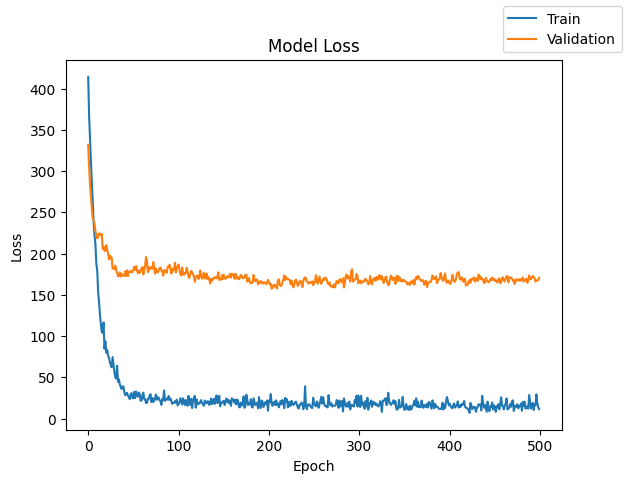

In [485]:
plot(history,'loss')

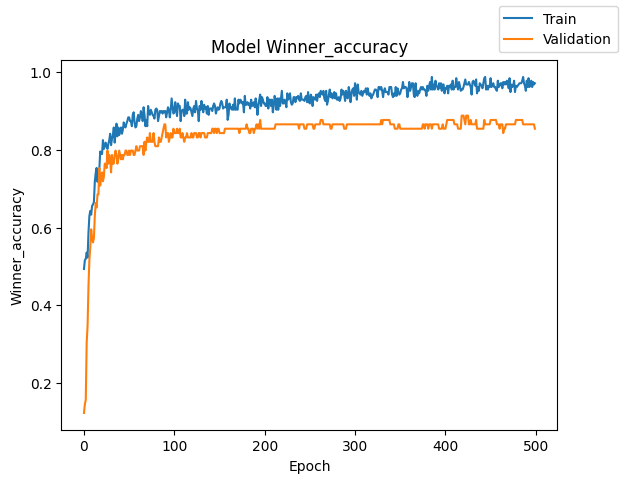

In [486]:
plot(history,'winner_accuracy')

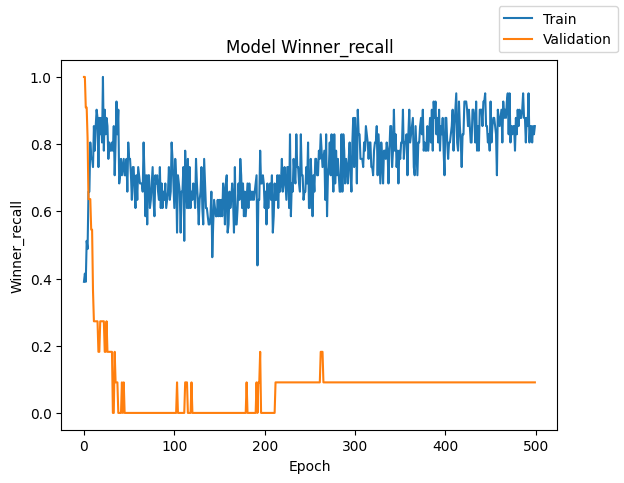

In [487]:
plot(history,'winner_recall')

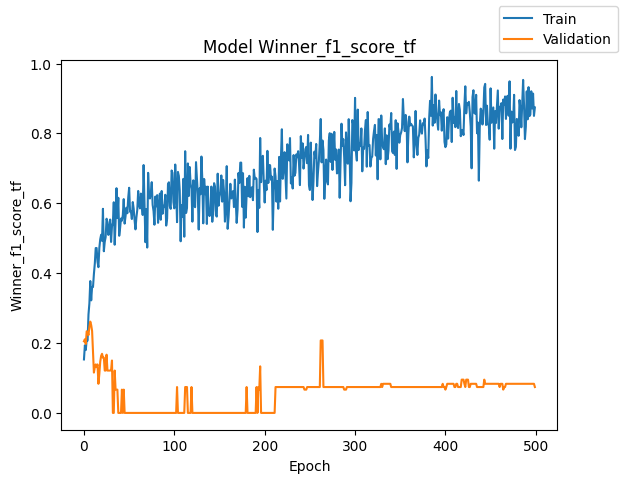

In [488]:
plot(history,'winner_f1_score_tf')

In [489]:
# Load the best saved model
best_model = load_model("best_model_joint.h5", compile=False)


### Regression Evaluation

In [490]:
# function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)[1]

    r2 = r2_score(target, pred)  # to compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
    mae = mean_absolute_error(target, pred)  # to compute MAE
    mape = mean_absolute_percentage_error(target, pred)  # to compute MAPE

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

In [491]:
model_1_train_perf = model_performance_regression(best_model, X_train, y_train_spread)
model_1_train_perf

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,1.464741,1.07731,0.993061,0.974336,0.122327


In [492]:
model_1_val_perf = model_performance_regression(best_model,X_val,y_val_spread)
model_1_val_perf

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,12.932231,10.395689,0.36962,1.407893,1.509465


In [493]:
model_1_test_perf = model_performance_regression(best_model,X_test,y_test_spread)
model_1_test_perf

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,14.291925,10.863481,0.254207,1.177177,1.271303


In [494]:
y_train_pred_1 = best_model.predict(X_train)[1]
y_val_pred_1 = best_model.predict(X_val)[1]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [495]:
#Find index for epoch with best validation loss value
min_val = min(history.history["val_loss"])
index = history.history["val_loss"].index(min_val)

print(min_val)
print(index)

157.33905029296875
203


In [496]:
# Make predictions on the full dataset

df_temp = df_filtered[X.columns].apply(lambda x: x.astype(str).str.replace("%", "")).apply(pd.to_numeric, errors="coerce")

X_transformed = pd.DataFrame(transformer.fit_transform(df_temp), columns=X.columns)

y_full_pred = best_model.predict(X_transformed)[1]


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [497]:
#  Add predictions to df_filtered
df_filtered['Predicted.Score.Diff'] = y_full_pred

In [498]:
# move Score.Diff and Predicted.Score.Diff to the 7th and 8th columns of the dataframe
cols = df_filtered.columns.tolist()
cols.insert(6, cols.pop(cols.index('Score.Diff')))
cols.insert(7, cols.pop(cols.index('Predicted.Score.Diff')))
df_filtered = df_filtered[cols]

In [499]:
# count the number of negative score.diffs
num_negative_diffs = (df_filtered['Score.Diff'] < 0).sum()

#count the number of negative predicted score.diffs when score.diff is negative
num_negative_predicted_diffs = df_filtered[(df_filtered['Score.Diff'] < 0) & (df_filtered['Predicted.Score.Diff'] < 0)].shape[0]

#count the number of negative predicted score.diffs when score.diff is positive
num_negative_predicted_diffs_positive = df_filtered[(df_filtered['Score.Diff'] > 0) & (df_filtered['Predicted.Score.Diff'] < 0)].shape[0]

# print num_negative_diffs and num_negative_predicted_diffs
print(f"Number of negative Score.Diff: {num_negative_diffs}")
print(f"Number of negative Predicted.Score.Diff when Score.Diff is negative: {num_negative_predicted_diffs}")
print(f"Number of negative Predicted.Score.Diff when Score.Diff is positive: {num_negative_predicted_diffs_positive}")


Number of negative Score.Diff: 119
Number of negative Predicted.Score.Diff when Score.Diff is negative: 97
Number of negative Predicted.Score.Diff when Score.Diff is positive: 5


### Classification Evaluation

In [500]:
# Defining a function to compute different metrics to check performance of a classification model built using statsmodels
import sklearn

def model_performance_classification(
    model, predictors, target, threshold=0.5
):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors)[0] > threshold
    # pred_temp = model.predict(predictors) > threshold
    # # rounding off the above values to get classes
    # pred = np.round(pred_temp)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred, average='binary')  # to compute Recall
    precision = precision_score(target, pred, average='binary')  # to compute Precision
    f1 = sklearn.metrics.f1_score(target, pred, average = 'binary')  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1 Score": f1,}, index = [0]
    )

    return df_perf

In [501]:
model_0_train_perf = model_performance_classification(best_model, X_train, y_train_winner)
model_0_train_perf

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


,Accuracy,Recall,Precision,F1 Score
0,0.974026,0.902439,0.902439,0.902439


In [502]:
model_0_val_perf = model_performance_classification(best_model,X_val,y_val_winner)
model_0_val_perf

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


,Accuracy,Recall,Precision,F1 Score
0,0.876404,0.181818,0.5,0.266667


In [503]:
model_0_test_perf = model_performance_classification(best_model,X_test,y_test_winner)
model_0_test_perf

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


,Accuracy,Recall,Precision,F1 Score
0,0.886364,0.333333,0.25,0.285714


In [504]:
y_train_pred = best_model.predict(X_train)[0]
y_val_pred = best_model.predict(X_val)[0]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [505]:
print("Classification Report - Train data Model_0",end="\n\n")
cr_train_model = classification_report(y_train_winner,y_train_pred>0.5)
print(cr_train_model)

Classification Report - Train data Model_0

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       267
           1       0.90      0.90      0.90        41

    accuracy                           0.97       308
   macro avg       0.94      0.94      0.94       308
weighted avg       0.97      0.97      0.97       308



In [506]:
print("Classification Report - Validation data Model_0",end="\n\n")
cr_val_model = classification_report(y_val_winner,y_val_pred>0.5)
print(cr_val_model)

Classification Report - Validation data Model_0

              precision    recall  f1-score   support

           0       0.89      0.97      0.93        78
           1       0.50      0.18      0.27        11

    accuracy                           0.88        89
   macro avg       0.70      0.58      0.60        89
weighted avg       0.85      0.88      0.85        89



In [507]:
#Find index for epoch with best validation loss value
max_val = max(history.history['val_winner_accuracy'])
index = history.history["val_winner_accuracy"].index(max_val)

print(max_val)
print(index)

0.8876404762268066
418


In [508]:
# Add the predicted probabilities to df_filtered
df_temp = df_filtered[X.columns].apply(lambda x: x.astype(str).str.replace("%", "")).apply(pd.to_numeric, errors="coerce")
X_transformed = pd.DataFrame(transformer.fit_transform(df_temp), columns=X.columns)
y_full_pred_prob = best_model.predict(X_transformed)[0]

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [509]:
#  Add predictions to df_filtered
df_filtered['Predicted.Underdog.Win.Prob'] = y_full_pred_prob

In [510]:
# Remove Predicted.Away.Win.Prob column if present
if 'Predicted.Away.Win.Prob' in df_filtered.columns:
    df_filtered = df_filtered.drop(columns=['Predicted.Away.Win.Prob'])

In [511]:
# move Away.Win and Predicted.Away.Win.Prob to the 7th and 8th columns of the dataframe
cols = df_filtered.columns.tolist()
cols.insert(6, cols.pop(cols.index('Underdog.Win')))
cols.insert(7, cols.pop(cols.index('Predicted.Underdog.Win.Prob')))
df_filtered = df_filtered[cols]

In [512]:
# Create name mappings for Sports Reference to TeamRankings
name_map = dict(zip(df_crosswalk["TeamRankingsName"], df_crosswalk["SportsReferenceName"]))

# Replace team names in the scores dataframe
df_filtered["Home"] = df_filtered["Home"].map(name_map)
df_filtered["Away"] = df_filtered["Away"].map(name_map)
df_filtered["Favorite"] = df_filtered["Favorite"].map(name_map)
df_filtered["Underdog"] = df_filtered["Underdog"].map(name_map)

In [513]:
df_filtered.head()

,Date.Game,Date.Stat,Home,Home.Points,Away,Away.Points,Underdog.Win,Predicted.Underdog.Win.Prob,Score.Diff,Predicted.Score.Diff,Favorite,Underdog,Total.Pts,Home_offensive-efficiency,Home_offensive-efficiency.Last3,Home_offensive-efficiency.Last1,Home_offensive-efficiency.Home,Home_three-point-pct,Home_three-point-pct.Last3,Home_three-point-pct.Last1,Home_three-point-pct.Home,Home_two-point-pct,Home_two-point-pct.Last3,Home_two-point-pct.Last1,Home_two-point-pct.Home,Home_free-throw-pct,Home_free-throw-pct.Last3,Home_free-throw-pct.Last1,Home_free-throw-pct.Home,Home_percent-of-points-from-3-pointers,Home_percent-of-points-from-3-pointers.Last3,Home_percent-of-points-from-3-pointers.Last1,Home_percent-of-points-from-3-pointers.Home,Home_points-per-game,Home_points-per-game.Last3,Home_points-per-game.Last1,Home_points-per-game.Home,Home_three-pointers-made-per-game,Home_three-pointers-made-per-game.Last3,Home_three-pointers-made-per-game.Last1,Home_three-pointers-made-per-game.Home,Home_free-throws-made-per-game,Home_free-throws-made-per-game.Last3,Home_free-throws-made-per-game.Last1,Home_free-throws-made-per-game.Home,Home_floor-percentage,Home_floor-percentage.Last3,Home_floor-percentage.Last1,Home_floor-percentage.Home,Home_turnovers-per-possession,Home_turnovers-per-possession.Last3,Home_turnovers-per-possession.Last1,Home_turnovers-per-possession.Home,Home_turnovers-per-game,Home_turnovers-per-game.Last3,Home_turnovers-per-game.Last1,Home_turnovers-per-game.Home,Home_assists-per-game,Home_assists-per-game.Last3,Home_assists-per-game.Last1,Home_assists-per-game.Home,Home_possessions-per-game,Home_possessions-per-game.Last3,Home_possessions-per-game.Last1,Home_possessions-per-game.Home,Home_offensive-rebounding-pct,Home_offensive-rebounding-pct.Last3,Home_offensive-rebounding-pct.Last1,Home_offensive-rebounding-pct.Home,Home_defensive-rebounding-pct,Home_defensive-rebounding-pct.Last3,Home_defensive-rebounding-pct.Last1,Home_defensive-rebounding-pct.Home,Home_total-rebounds-per-game,Home_total-rebounds-per-game.Last3,Home_total-rebounds-per-game.Last1,Home_total-rebounds-per-game.Home,Home_total-rebounding-percentage,Home_total-rebounding-percentage.Last3,Home_total-rebounding-percentage.Last1,Home_total-rebounding-percentage.Home,Home_extra-chances-per-game,Home_extra-chances-per-game.Last3,Home_extra-chances-per-game.Last1,Home_extra-chances-per-game.Home,Home_defensive-efficiency,Home_defensive-efficiency.Last3,Home_defensive-efficiency.Last1,Home_defensive-efficiency.Home,Home_blocks-per-game,Home_blocks-per-game.Last3,Home_blocks-per-game.Last1,Home_blocks-per-game.Home,Home_steals-per-game,Home_steals-per-game.Last3,Home_steals-per-game.Last1,Home_steals-per-game.Home,Home_block-pct,Home_block-pct.Last3,Home_block-pct.Last1,Home_block-pct.Home,Home_steals-perpossession,Home_steals-perpossession.Last3,Home_steals-perpossession.Last1,Home_steals-perpossession.Home,Home_personal-fouls-per-possession,Home_personal-fouls-per-possession.Last3,Home_personal-fouls-per-possession.Last1,Home_personal-fouls-per-possession.Home,Home_win-pct-all-games,Home_win-pct-all-games.Last3,Home_win-pct-all-games.Last1,Home_win-pct-all-games.Home,Home_effective-possession-ratio,Home_effective-possession-ratio.Last3,Home_effective-possession-ratio.Last1,Home_effective-possession-ratio.Home,Home_opponent-effective-possession-ratio,Home_opponent-effective-possession-ratio.Last3,Home_opponent-effective-possession-ratio.Last1,Home_opponent-effective-possession-ratio.Home,Home_schedule-strength-by-other,Home_predictive-by-other,Home_consistency-by-other,Away_offensive-efficiency,Away_offensive-efficiency.Last3,Away_offensive-efficiency.Last1,Away_offensive-efficiency.Away,Away_three-point-pct,Away_three-point-pct.Last3,Away_three-point-pct.Last1,Away_three-point-pct.Away,Away_two-point-pct,Away_two-point-pct.Last3,Away_two-point-pct.Last1,Away_two-point-pct.Away,Away_free-throw-pct,Away_free-throw-pct.Last3,Away_free-throw-pct.Last1,Away_free-throw

In [514]:
# Show games where Gonzaga is playing
df_filtered[(df_filtered['Home'] == 'Gonzaga') | (df_filtered['Away'] == 'Gonzaga')]

,Date.Game,Date.Stat,Home,Home.Points,Away,Away.Points,Underdog.Win,Predicted.Underdog.Win.Prob,Score.Diff,Predicted.Score.Diff,Favorite,Underdog,Total.Pts,Home_offensive-efficiency,Home_offensive-efficiency.Last3,Home_offensive-efficiency.Last1,Home_offensive-efficiency.Home,Home_three-point-pct,Home_three-point-pct.Last3,Home_three-point-pct.Last1,Home_three-point-pct.Home,Home_two-point-pct,Home_two-point-pct.Last3,Home_two-point-pct.Last1,Home_two-point-pct.Home,Home_free-throw-pct,Home_free-throw-pct.Last3,Home_free-throw-pct.Last1,Home_free-throw-pct.Home,Home_percent-of-points-from-3-pointers,Home_percent-of-points-from-3-pointers.Last3,Home_percent-of-points-from-3-pointers.Last1,Home_percent-of-points-from-3-pointers.Home,Home_points-per-game,Home_points-per-game.Last3,Home_points-per-game.Last1,Home_points-per-game.Home,Home_three-pointers-made-per-game,Home_three-pointers-made-per-game.Last3,Home_three-pointers-made-per-game.Last1,Home_three-pointers-made-per-game.Home,Home_free-throws-made-per-game,Home_free-throws-made-per-game.Last3,Home_free-throws-made-per-game.Last1,Home_free-throws-made-per-game.Home,Home_floor-percentage,Home_floor-percentage.Last3,Home_floor-percentage.Last1,Home_floor-percentage.Home,Home_turnovers-per-possession,Home_turnovers-per-possession.Last3,Home_turnovers-per-possession.Last1,Home_turnovers-per-possession.Home,Home_turnovers-per-game,Home_turnovers-per-game.Last3,Home_turnovers-per-game.Last1,Home_turnovers-per-game.Home,Home_assists-per-game,Home_assists-per-game.Last3,Home_assists-per-game.Last1,Home_assists-per-game.Home,Home_possessions-per-game,Home_possessions-per-game.Last3,Home_possessions-per-game.Last1,Home_possessions-per-game.Home,Home_offensive-rebounding-pct,Home_offensive-rebounding-pct.Last3,Home_offensive-rebounding-pct.Last1,Home_offensive-rebounding-pct.Home,Home_defensive-rebounding-pct,Home_defensive-rebounding-pct.Last3,Home_defensive-rebounding-pct.Last1,Home_defensive-rebounding-pct.Home,Home_total-rebounds-per-game,Home_total-rebounds-per-game.Last3,Home_total-rebounds-per-game.Last1,Home_total-rebounds-per-game.Home,Home_total-rebounding-percentage,Home_total-rebounding-percentage.Last3,Home_total-rebounding-percentage.Last1,Home_total-rebounding-percentage.Home,Home_extra-chances-per-game,Home_extra-chances-per-game.Last3,Home_extra-chances-per-game.Last1,Home_extra-chances-per-game.Home,Home_defensive-efficiency,Home_defensive-efficiency.Last3,Home_defensive-efficiency.Last1,Home_defensive-efficiency.Home,Home_blocks-per-game,Home_blocks-per-game.Last3,Home_blocks-per-game.Last1,Home_blocks-per-game.Home,Home_steals-per-game,Home_steals-per-game.Last3,Home_steals-per-game.Last1,Home_steals-per-game.Home,Home_block-pct,Home_block-pct.Last3,Home_block-pct.Last1,Home_block-pct.Home,Home_steals-perpossession,Home_steals-perpossession.Last3,Home_steals-perpossession.Last1,Home_steals-perpossession.Home,Home_personal-fouls-per-possession,Home_personal-fouls-per-possession.Last3,Home_personal-fouls-per-possession.Last1,Home_personal-fouls-per-possession.Home,Home_win-pct-all-games,Home_win-pct-all-games.Last3,Home_win-pct-all-games.Last1,Home_win-pct-all-games.Home,Home_effective-possession-ratio,Home_effective-possession-ratio.Last3,Home_effective-possession-ratio.Last1,Home_effective-possession-ratio.Home,Home_opponent-effective-possession-ratio,Home_opponent-effective-possession-ratio.Last3,Home_opponent-effective-possession-ratio.Last1,Home_opponent-effective-possession-ratio.Home,Home_schedule-strength-by-other,Home_predictive-by-other,Home_consistency-by-other,Away_offensive-efficiency,Away_offensive-efficiency.Last3,Away_offensive-efficiency.Last1,Away_offensive-efficiency.Away,Away_three-point-pct,Away_three-point-pct.Last3,Away_three-point-pct.Last1,Away_three-point-pct.Away,Away_two-point-pct,Away_two-point-pct.Last3,Away_two-point-pct.Last1,Away_two-point-pct.Away,Away_free-throw-pct,Away_free-throw-pct.Last3,Away_free-throw-pct.Last1,Away_free-throw

In [515]:
# Save df_filtered to a pickle file
with open("NCAA_Basketball_Spread_Predictions_2025_2026.rds", "wb") as f:
    pickle.dump(df_filtered, f)

print("DataFrame saved to NCAA_Basketball_Spread_Predictions_2025_2026.rds")

DataFrame saved to NCAA_Basketball_Spread_Predictions_2025_2026.rds
